In [15]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import datetime as dt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
import cartopy.io.img_tiles as cimgt

from sklearn.linear_model import QuantileRegressor

In [2]:
icn_ds = xr.open_dataset('ICN_heat_metrics_1989-2024_2025-04-17_daily_max.nc')

era_ds = xr.open_dataset('/data/cristi/a/kchoo3/ERA5/reanalysis/analysis-ready/daily_max/ERA5_MIDWEST_heat_metrics_1940-2024_2025-04-15_daily_max.nc')
era_ds = era_ds.sortby('lat', ascending=True) # fix the lat coord to be ascending (it's unorganized for some reason)

icn_trend = 

In [3]:
def assign_coordinates(ds):
    station_locs = {
        'Champaign':   (40.085571, -88.240141),
        'Springfield': (39.721302, -89.613882),
        'Carbondale':  (37.699711, -89.244105),
    }

    stations = ds.station.values
    
    lats = [station_locs[name][0] for name in stations]
    lons = [station_locs[name][1] for name in stations]

    ds = ds.assign_coords({
        'lat': ('station', lats),
        'lon': ('station', lons),
    })

    return ds;

icn_ds = assign_coordinates(icn_ds)

In [39]:
icn_ds.t2m.isel(station=2)

<xarray.DataArray 't2m' (date: 3312)> Size: 26kB
[3312 values with dtype=float64]
Coordinates:
    station  <U11 44B 'Carbondale'
  * date     (date) datetime64[ns] 26kB 1989-06-01 1989-06-02 ... 2024-08-31
    lat      float64 8B 37.7
    lon      float64 8B -89.24
Attributes:
    units:        Celsius
    description:  Temperature in Celsius

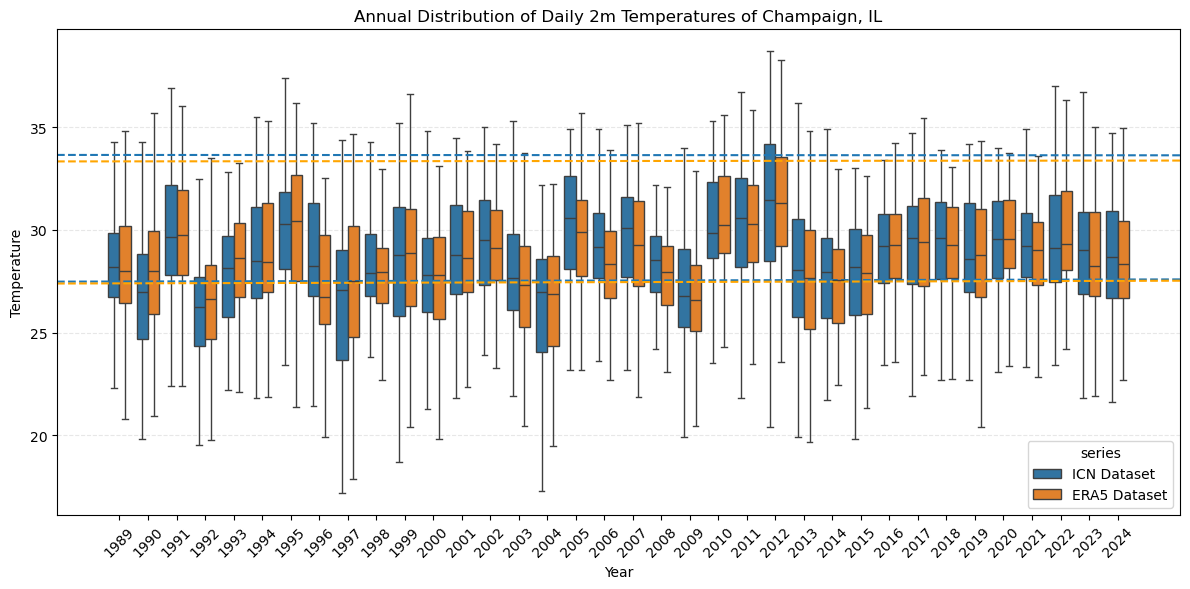

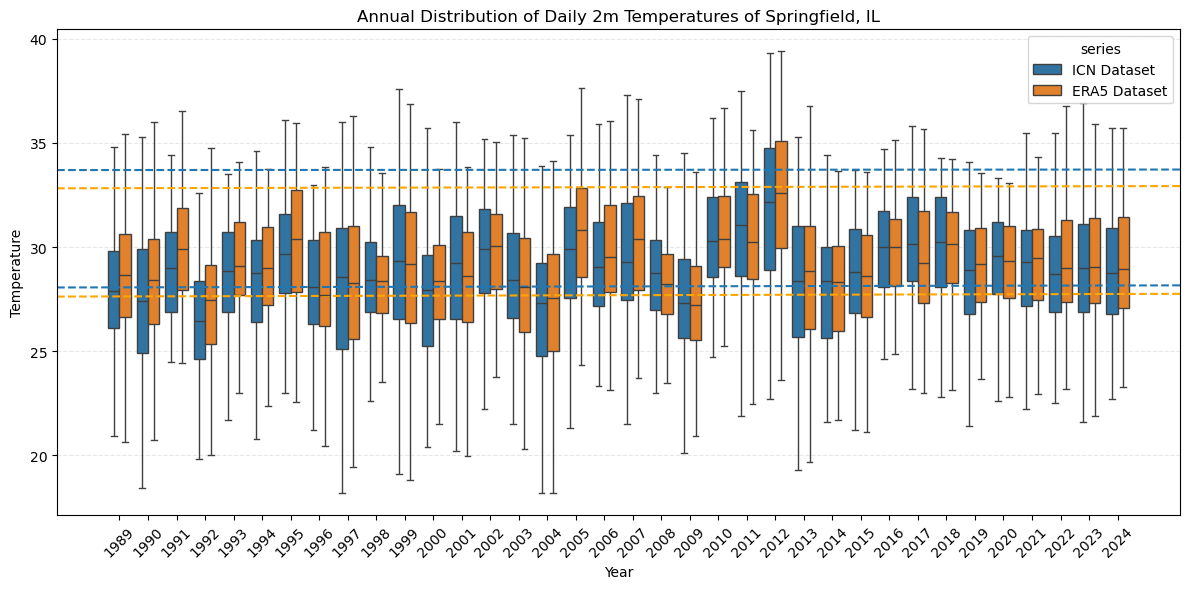

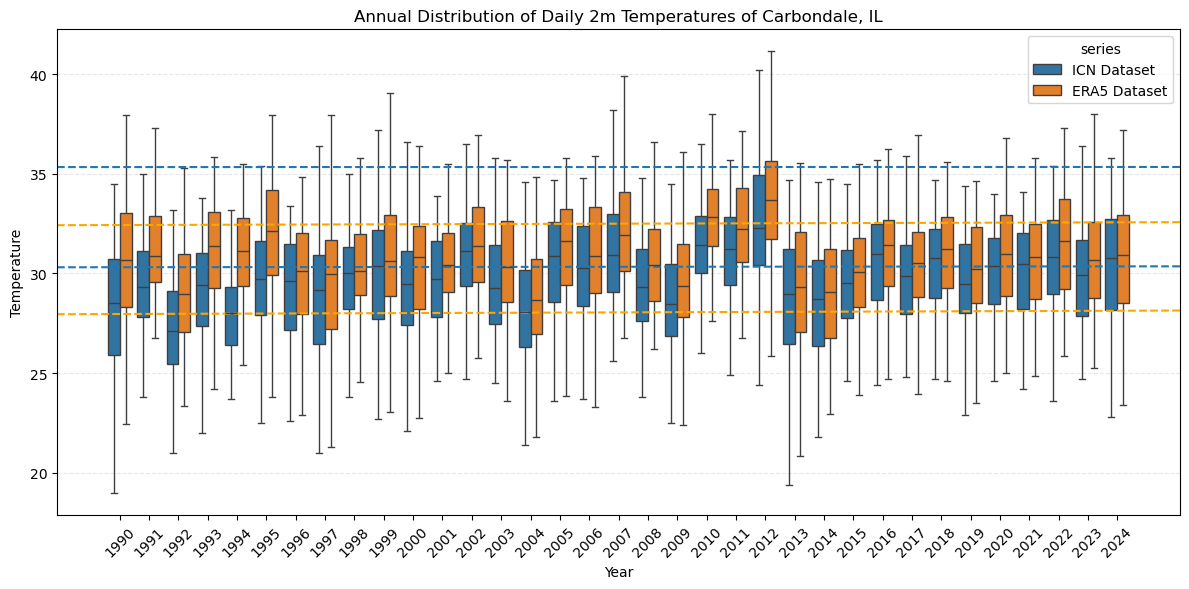

In [43]:
def quantile_regression(y, X, quantile):
    y = y.fillna(y.mean())
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    qr.fit(X, y)
    return np.array([qr.coef_[0] * 35, qr.intercept_])

quantiles = [int('95'), int('50')]
variables = ['t2m', 'wb', 'hi']

# slope, intercept = quantile_regression(era_da,X,0.95)
# print(slope * 365.25 * 35)
# print(intercept)

for i in range(3):
    icn_da = icn_ds.t2m.isel(station=i)
    
    era_da = era_ds.t2m.sel(lat=icn_da.lat.data, lon=(icn_da.lon.data+360), method='nearest')
    year_i = '1989-01-01'
    if i == 2:
        year_i = '1990-01-01'
        icn_da = icn_da.sel(date=slice(year_i, '2024-12-31'))
    
    era_da = era_da.sel(date=slice(year_i, '2024-12-31'))

    X = era_da.date.values[:, np.newaxis].astype('datetime64[D]').astype('int64')
    
    df = pd.DataFrame({
        "value": np.concatenate([icn_da.values, era_da.values]),
        "year": np.concatenate([icn_da.date.dt.year.values, era_da.date.dt.year.values]),
        "series": ["ICN Dataset"]*icn_da.size + ["ERA5 Dataset"]*era_da.size
    })
    
    plt.figure(figsize=(12, 6))

    # box plot
    ax = sns.boxplot(x="year", y="value", hue="series", data=df, showfliers=False)

    #strip plot
    # sns.stripplot(x="year", y="value", hue="series", data=df, jitter=0.05, size=2)

    # Quantile Regression

    slope, intercept = quantile_regression(era_da,X,0.95)
    ax.axline((0, intercept), slope=slope, linestyle='--')
    slope, intercept = quantile_regression(era_da,X,0.50)
    ax.axline((0, intercept), slope=slope, linestyle='--')

    slope, intercept = quantile_regression(icn_da,X,0.95)
    ax.axline((0, intercept), slope=slope, color='orange', linestyle='--')
    slope, intercept = quantile_regression(icn_da,X,0.50)
    ax.axline((0, intercept), slope=slope, color='orange', linestyle='--')
                  
    plt.xticks(rotation=45)
    plt.ylabel("Temperature")
    plt.xlabel("Year")
    plt.title(f"Annual Distribution of Daily 2m Temperatures of {icn_da.station.data}, IL")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.tight_layout()

In [17]:
def quantile_regression(y, X, quantile):
    qr = QuantileRegressor(quantile=quantile, alpha=0)
    qr.fit(X, y)
    return np.array([qr.coef_[0], qr.intercept_])

quantiles = [int('95'), int('50')]
variables = ['t2m', 'wb', 'hi']

X = era_da.date.values[:, np.newaxis].astype('datetime64[D]').astype('int64')

slope, intercept = quantile_regression(era_da,X,0.95)
print(slope * 265.25 * 35)
print(intercept)

0.20748040895689376
35.013865466158904
